# NCC-PINN - Colab GPU Runner

This notebook trains Physics-Informed Neural Networks (PINNs) and analyzes internal representations with Nearest Class Centroid (NCC) on Google Colab GPU.

**Features:**
- Mounts Google Drive for persistent storage
- Clones the NCC-PINN repository from GitHub
- Installs dependencies with CUDA support
- Runs training + NCC analysis pipeline
- Auto-generates datasets if missing
- Auto-saves all outputs (plots, metrics, checkpoints) to Drive

**Runtime:** GPU (T4 or better recommended)

---


## 1. Check GPU Availability


In [ ]:
# Check if GPU is available
!nvidia-smi


## 2. Mount Google Drive

All outputs will be saved to: `/content/drive/MyDrive/NCC-PINN/`


In [ ]:
from google.colab import drive
import os

# Mount Drive
drive.mount('/content/drive')

# Create output directory on Drive
DRIVE_OUTPUT_DIR = '/content/drive/MyDrive/NCC-PINN'
os.makedirs(DRIVE_OUTPUT_DIR, exist_ok=True)

print(f"\n✓ Drive mounted. Outputs will be saved to: {DRIVE_OUTPUT_DIR}")


## 3. Clone Repository


In [ ]:
# Configuration
REPO_URL = "https://github.com/assafzimand/NCC-PINN.git"
REPO_NAME = "NCC-PINN"
WORK_DIR = f"/content/{REPO_NAME}"

# Clone or update repository
if os.path.exists(WORK_DIR):
    print(f"Repository already exists at {WORK_DIR}")
    print("Pulling latest changes...")
    !cd {WORK_DIR} && git pull
else:
    print(f"Cloning repository from {REPO_URL}...")
    !git clone {REPO_URL} {WORK_DIR}

# Change to repo directory
os.chdir(WORK_DIR)
print(f"\n✓ Working directory: {os.getcwd()}")


## 4. Install Dependencies


In [ ]:
# Install PyTorch with CUDA for Colab (CUDA 12.1)
print("Installing PyTorch with CUDA support...")
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121 --quiet

print("\nInstalling project dependencies...")
%pip install -r requirements.txt --quiet

# Verify CUDA is available
import torch
print(f"\n✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ CUDA version: {torch.version.cuda}")
    print(f"✓ GPU device: {torch.cuda.get_device_name(0)}")
else:
    print("⚠ WARNING: CUDA not available! Training will be slow on CPU.")


## 5. (Optional) View Configuration

View the current training configuration before running.


In [ ]:
# Display current configuration
!cat config/config.yaml


## 6. Run Training + NCC Analysis & Auto-Save to Drive

**This cell does everything:**
1. Generates datasets if they don't exist
2. Trains the PINN model
3. Runs NCC analysis
4. Saves all results to Google Drive

**Note:** This may take 10-30 minutes depending on configuration and GPU type.


In [ ]:
import shutil
from pathlib import Path
from datetime import datetime

print("="*70)
print("NCC-PINN: Training + NCC Analysis")
print("="*70)

# Run the complete pipeline (dataset gen + training + NCC)
!python run_ncc.py

print("\n" + "="*70)
print("Pipeline Complete! Saving results to Google Drive...")
print("="*70)

# Create timestamped backup folder on Drive
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
backup_dir = Path(DRIVE_OUTPUT_DIR) / f"run_{timestamp}"
backup_dir.mkdir(parents=True, exist_ok=True)

print(f"\nSaving to: {backup_dir}\n")

# 1. Copy outputs directory (training plots, NCC plots, metrics, summary)
outputs_dir = Path("outputs")
if outputs_dir.exists():
    print("Copying outputs (training plots, NCC plots, metrics)...")
    for problem_dir in outputs_dir.iterdir():
        if problem_dir.is_dir():
            dest = backup_dir / "outputs" / problem_dir.name
            shutil.copytree(problem_dir, dest, dirs_exist_ok=True)
            print(f"  ✓ Copied {problem_dir.name}")
else:
    print("⚠ No outputs directory found")

# 2. Copy checkpoints directory (best_model.pt, final_model.pt, etc.)
checkpoints_dir = Path("checkpoints")
if checkpoints_dir.exists():
    print("\nCopying checkpoints...")
    for problem_dir in checkpoints_dir.iterdir():
        if problem_dir.is_dir():
            dest = backup_dir / "checkpoints" / problem_dir.name
            shutil.copytree(problem_dir, dest, dirs_exist_ok=True)
            print(f"  ✓ Copied {problem_dir.name}")
else:
    print("⚠ No checkpoints directory found")

# 3. Copy dataset visualizations ONLY (not the .pt data files)
datasets_dir = Path("datasets")
if datasets_dir.exists():
    print("\nCopying dataset visualizations...")
    for problem_dir in datasets_dir.iterdir():
        if problem_dir.is_dir():
            dest = backup_dir / "datasets" / problem_dir.name
            dest.mkdir(parents=True, exist_ok=True)
            
            # Copy only visualization files (PNG, not .pt data files)
            for viz_file in problem_dir.glob("*.png"):
                shutil.copy2(viz_file, dest / viz_file.name)
                print(f"  ✓ Copied {problem_dir.name}/{viz_file.name}")
else:
    print("⚠ No datasets directory found")

# 4. Copy the configuration used
config_file = Path("config/config.yaml")
if config_file.exists():
    print("\nCopying configuration...")
    dest_config = backup_dir / "config.yaml"
    shutil.copy2(config_file, dest_config)
    print(f"  ✓ Copied config.yaml")

print(f"\n{'='*70}")
print(f"✓ All results saved to Google Drive!")
print(f"{'='*70}")
print(f"\nLocation: MyDrive/NCC-PINN/run_{timestamp}/")
print(f"\nSaved structure:")
print(f"  - outputs/<problem>/ (training plots, NCC plots, metrics.json, summary.txt)")
print(f"  - checkpoints/<problem>/ (best_model.pt, final_model.pt, etc.)")
print(f"  - datasets/<problem>/ (dataset visualizations only)")
print(f"  - config.yaml (configuration used for this run)")
print(f"\n{'='*70}")


## 7. View Training Results


In [ ]:
from IPython.display import Image, display
import json

# Find the output directory
outputs_dir = Path("outputs")
problem_dirs = [d for d in outputs_dir.iterdir() if d.is_dir()]

if problem_dirs:
    latest_run = problem_dirs[0]  # Assuming single run
    print(f"Displaying results from: {latest_run.name}\n")
    
    # Load and display metrics
    metrics_file = latest_run / "metrics.json"
    if metrics_file.exists():
        with open(metrics_file, 'r') as f:
            metrics = json.load(f)
        
        print("="*70)
        print("Training Metrics Summary")
        print("="*70)
        print(f"Total epochs: {len(metrics.get('train_loss_epochs', []))}") 
        if metrics.get('train_loss'):
            print(f"Final train loss: {metrics['train_loss'][-1]:.6f}")
        if metrics.get('eval_loss'):
            print(f"Final eval loss: {metrics['eval_loss'][-1]:.6f}")
        if metrics.get('train_rel_l2'):
            print(f"Final train rel-L2: {metrics['train_rel_l2'][-1]:.6f}")
        if metrics.get('eval_rel_l2'):
            print(f"Final eval rel-L2: {metrics['eval_rel_l2'][-1]:.6f}")
        print("="*70 + "\n")
    
    # Display training curves
    training_plots_dir = latest_run / "training_plots"
    if training_plots_dir.exists():
        training_curves = training_plots_dir / "training_curves.png"
        if training_curves.exists():
            print("Training Curves:")
            display(Image(filename=str(training_curves)))
    
    # Display NCC accuracy plot
    ncc_plots_dir = latest_run / "ncc_plots"
    if ncc_plots_dir.exists():
        ncc_accuracy = ncc_plots_dir / "ncc_layer_accuracy.png"
        if ncc_accuracy.exists():
            print("\nNCC Layer Accuracy:")
            display(Image(filename=str(ncc_accuracy)))
        
        ncc_compactness = ncc_plots_dir / "ncc_compactness.png"
        if ncc_compactness.exists():
            print("\nNCC Compactness:")
            display(Image(filename=str(ncc_compactness)))
else:
    print("No output directories found. Make sure training completed successfully.")


## 8. View Dataset Visualizations


In [ ]:
from IPython.display import Image, display

# Find dataset visualizations
datasets_dir = Path("datasets")
problem_dirs = [d for d in datasets_dir.iterdir() if d.is_dir()]

if problem_dirs:
    for problem_dir in problem_dirs:
        print(f"Dataset: {problem_dir.name}\n")
        print("="*70)
        
        # Show dataset visualization plots
        for viz_file in sorted(problem_dir.glob("*.png")):
            print(f"\n{viz_file.name}:")
            display(Image(filename=str(viz_file)))
else:
    print("No dataset visualizations found.")


## Notes & Tips

---

### Configuration
- Edit `config/config.yaml` in the repository to customize:
  - Problem to solve (`schrodinger`, `problem2`)
  - Architecture (layer sizes)
  - Learning rate, batch size, epochs
  - Loss weights (residual, IC, BC)
  - NCC bins

### Pipeline Steps
1. **Dataset Generation**: `run_ncc.py` checks if datasets exist and generates them if missing
2. **Training**: Trains PINN model with physics-informed loss
3. **NCC Analysis**: Analyzes internal representations across all hidden layers

### Outputs
- **`outputs/<problem>/`**:
  - `training_plots/`: Loss curves and predictions
  - `ncc_plots/`: NCC accuracy, compactness, geometry, margins, confusion matrices
  - `metrics.json`: Training metrics (loss, rel-L2 error)
  - `summary.txt`: Training summary
  - Problem-specific visualizations (e.g., Schrödinger heatmaps)
  
- **`checkpoints/<problem>/`**: Saved model checkpoints
- **`datasets/<problem>/`**: Dataset visualizations

### Tips
- **Use GPU runtime**: Runtime → Change runtime type → GPU (T4 recommended)
- **Long runs**: Keep browser tab open or use Colab Pro for extended sessions
- **Results persist**: All results are auto-saved to Drive with timestamp
- **Resume training**: Use `resume_from` in config to continue from checkpoint

---


# Schrödinger PINN - Grid Search on Colab GPU

This notebook runs hyperparameter grid search for the Schrödinger equation PINN on Google Colab GPU.

**Features:**
- Mounts Google Drive for persistent storage
- Clones the repository from Git
- Installs dependencies with CUDA support
- Runs grid search with MLflow tracking
- Auto-saves all outputs (plots, evaluations, checkpoints) to Drive

**Runtime:** GPU (T4 or better recommended)

---


## 1. Check GPU Availability


In [1]:
# Check if GPU is available
!nvidia-smi


Wed Oct 29 07:57:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   67C    P8             15W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Mount Google Drive

All outputs will be saved to: `/content/drive/MyDrive/Schrodinger_PINN/`


In [2]:
from google.colab import drive
import os

# Mount Drive
drive.mount('/content/drive')

# Create output directory on Drive
DRIVE_OUTPUT_DIR = '/content/drive/MyDrive/Schrodinger_PINN'
os.makedirs(DRIVE_OUTPUT_DIR, exist_ok=True)

print(f"\n✓ Drive mounted. Outputs will be saved to: {DRIVE_OUTPUT_DIR}")


Mounted at /content/drive

✓ Drive mounted. Outputs will be saved to: /content/drive/MyDrive/Schrodinger_PINN


## 3. Clone Repository

**⚠️ IMPORTANT:** Update the Git repository URL below with your actual repo URL.


In [3]:
# Configuration
REPO_URL = "https://github.com/assafzimand/Schrodinger-Equation.git"  # ⚠️ UPDATE THIS
REPO_NAME = "Schrodinger_Equation"
WORK_DIR = f"/content/{REPO_NAME}"

# Clone or update repository
if os.path.exists(WORK_DIR):
    print(f"Repository already exists at {WORK_DIR}")
    print("Pulling latest changes...")
    !cd {WORK_DIR} && git pull
else:
    print(f"Cloning repository from {REPO_URL}...")
    !git clone {REPO_URL} {WORK_DIR}

# Change to repo directory
os.chdir(WORK_DIR)
print(f"\n✓ Working directory: {os.getcwd()}")


Cloning repository from https://github.com/assafzimand/Schrodinger-Equation.git...
Cloning into '/content/Schrodinger_Equation'...
remote: Enumerating objects: 1635, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 1635 (delta 0), reused 0 (delta 0), pack-reused 1623 (from 3)
Receiving objects: 100% (1635/1635), 49.05 MiB | 21.66 MiB/s, done.
Resolving deltas: 100% (115/115), done.

✓ Working directory: /content/Schrodinger_Equation


## 4. Install Dependencies

In [4]:
# Install PyTorch with CUDA for Colab (usually CUDA 12.x)
print("Installing PyTorch with CUDA support...")
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121

print("\nInstalling other dependencies...")
%pip install numpy scipy matplotlib seaborn PyYAML mlflow pandas

# Verify CUDA is available
import torch
print(f"\n✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ CUDA version: {torch.version.cuda}")
    print(f"✓ GPU device: {torch.cuda.get_device_name(0)}")


Installing PyTorch with CUDA support...
Looking in indexes: https://download.pytorch.org/whl/cu121

Installing other dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.6/752.6 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 20.8 MB/s eta 0:00:00

✓ PyTorch version: 2.8.0+cu126
✓ CUDA available: True
✓ CUDA version: 12.6
✓ GPU device: NVIDIA L4


## 5. Generate Training and Evaluation Datasets

Generate the datasets if they don't exist.


In [5]:
import os

# Check if datasets exist
train_dataset_path = "data/processed/dataset.npz"
eval_dataset_path = "data/processed/dataset_eval.npz"

if not os.path.exists(train_dataset_path):
    print("Generating training dataset...")
    !python src/data/generate_dataset.py
else:
    print(f"✓ Training dataset exists: {train_dataset_path}")

if not os.path.exists(eval_dataset_path):
    print("\nGenerating evaluation dataset...")
    !python src/data/generate_eval_dataset.py
else:
    print(f"✓ Evaluation dataset exists: {eval_dataset_path}")

print("\n✓ Datasets ready!")


✓ Training dataset exists: data/processed/dataset.npz
✓ Evaluation dataset exists: data/processed/dataset_eval.npz

✓ Datasets ready!


## 6. Configure Grid Search

View current grid search configuration.


In [6]:
# Display current grid search configuration
!cat config/grid_search.yaml


# Grid Search Configuration
# Searches over loss weights and batch sizes to find optimal hyperparameters

grid_search:
  # Base configuration (will be overridden by grid parameters)
  base_config: config/train.yaml
  
  # Number of epochs for each run
  epochs: 20
  
  # Grid parameters to search
  parameters:
    # Initial condition loss weight
    # Based on analysis: 1.0 (paper), 10, 20 (moderate boost)
    weight_initial: [400]
    
    # Boundary condition weight (keep constant)
    weight_boundary: [1]
    
    # PDE residual weight (try boosting to improve time evolution)
    weight_residual: [400]
    
    # Batch size (affects gradient noise and convergence)
    batch_size: [512]
  
  # MLflow experiment name for grid search
  experiment_name: schrodinger_grid_search
  
  # Save results summary
  results_file: outputs/grid_search_results.csv
  
  # Early stopping criteria (optional)
  early_stopping:
    enabled: false
    patience: 100
    min_delta: 0.001



### Optional: Modify Grid Search Parameters

In [7]:
import yaml

# Example: Modify grid search parameters (uncomment to use)
# config_path = 'config/grid_search.yaml'
# with open(config_path, 'r') as f:
#     config = yaml.safe_load(f)
#
# # Modify parameters
# config['grid_search']['epochs'] = 100
# config['grid_search']['parameters']['weight_initial'] = [1, 10, 100]
# config['grid_search']['parameters']['weight_residual'] = [1, 10, 100]
# config['grid_search']['parameters']['batch_size'] = [512, 1024]
#
# # Save modified config
# with open(config_path, 'w') as f:
#     yaml.dump(config, f, default_flow_style=False)
#
# print("✓ Grid search config updated")


## 7. Run Grid Search & Auto-Save to Drive

This cell runs the grid search and automatically saves results to Drive when complete.

In [ ]:
import shutil
from pathlib import Path
from datetime import datetime
import mlflow

# Run grid search with auto-confirmation
!python grid_search.py --yes

print("\n" + "="*70)
print("Grid Search Complete! Saving results to Google Drive...")
print("="*70)

# Get the most recent MLflow run IDs from the grid search experiment
mlflow.set_tracking_uri("file:./mlruns")
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("schrodinger_grid_search")

if experiment:
    # Get all runs from this experiment
    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=["start_time DESC"],
    )
    
    # Create timestamped backup folder on Drive
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    backup_dir = Path(DRIVE_OUTPUT_DIR) / f"grid_search_{timestamp}"
    backup_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"\nSaving to: {backup_dir}\n")
    
    # Copy grid search summary
    results_csv = Path("outputs/grid_search_results.csv")
    if results_csv.exists():
        shutil.copy2(results_csv, backup_dir / "grid_search_results.csv")
        print(f"✓ Copied grid search summary")
    
    # Process each run in this grid search
    for run in runs:
        run_id = run.info.run_id
        print(f"\nProcessing run: {run_id}")
        
        # Run evaluation if not already done (or to ensure fresh plots)
        best_checkpoint = Path("outputs/checkpoints/best_model.pt")
        eval_output_dir = Path(f"outputs/evaluation/{run_id}")
        
        if best_checkpoint.exists():
            print(f"  Running evaluation on best model...")
            !python -m src.evaluate.evaluate_model \
                --checkpoint {best_checkpoint} \
                --output-dir {eval_output_dir} \
                --device cuda
            print(f"  ✓ Evaluation complete")
        
        # Create run-specific folder
        run_backup_dir = backup_dir / run_id
        run_backup_dir.mkdir(exist_ok=True)
        
        # Copy plots
        plots_dir = Path(f"outputs/plots/{run_id}")
        if plots_dir.exists():
            shutil.copytree(plots_dir, run_backup_dir / "plots", dirs_exist_ok=True)
            print(f"  ✓ Copied plots")
        
        # Copy evaluation
        if eval_output_dir.exists():
            shutil.copytree(eval_output_dir, run_backup_dir / "evaluation", dirs_exist_ok=True)
            print(f"  ✓ Copied evaluation")
        else:
            print(f"  ⚠ No evaluation found for {run_id}")
        
        # Copy checkpoints (best_model.pt and final_model.pt)
        checkpoints_dir = Path("outputs/checkpoints")
        if checkpoints_dir.exists():
            checkpoint_backup = run_backup_dir / "checkpoints"
            checkpoint_backup.mkdir(exist_ok=True)
            for ckpt in ["best_model.pt", "final_model.pt"]:
                ckpt_path = checkpoints_dir / ckpt
                if ckpt_path.exists():
                    shutil.copy2(ckpt_path, checkpoint_backup / ckpt)
            print(f"  ✓ Copied checkpoints")
    
    # Copy MLflow metadata for this experiment only
    mlflow_backup = backup_dir / "mlruns"
    mlflow_backup.mkdir(exist_ok=True)
    exp_dir = Path(f"mlruns/{experiment.experiment_id}")
    if exp_dir.exists():
        shutil.copytree(exp_dir, mlflow_backup / experiment.experiment_id, dirs_exist_ok=True)
        print(f"\n✓ Copied MLflow experiment data")
    
    print(f"\n{'='*70}")
    print(f"✓ All results saved to Google Drive!")
    print(f"{'='*70}")
    print(f"\nLocation: MyDrive/Schrodinger_PINN/grid_search_{timestamp}/")
    print(f"  - grid_search_results.csv (summary)")
    print(f"  - {len(runs)} run folders with plots, evaluations, and checkpoints")
    print(f"  - mlruns/ (MLflow tracking data)")
else:
    print("⚠ Could not find grid search experiment in MLflow")


GRID SEARCH - Schrödinger PINN Hyperparameter Optimization

Grid Configuration:
  Total combinations: 1
  Epochs per run: 20
  Base config: config/train.yaml
  Parameters:
    weight_initial: [400]
    weight_boundary: [1]
    weight_residual: [400]
    batch_size: [512]

  Estimated time per run: 1.3 minutes
  Estimated total time: 0.0 hours

[Auto-Confirm] Proceeding with 1 runs.
2025/10/29 07:59:27 INFO mlflow.tracking.fluent: Experiment with name 'schrodinger_grid_search' does not exist. Creating a new experiment.

Run 1/1
  weight_initial=400
  weight_residual=400
  batch_size=512
Full Training Run - Schrödinger PINN

Device: cuda
GPU: NVIDIA L4

Loading training dataset: data/processed/dataset.npz
  Total collocation: 20000
  Initial: 50
  Boundary: 100

Using ENTIRE dataset for training (no split)...

Loading evaluation dataset: data/processed/dataset_eval.npz
  Eval collocation: 5000
  Eval initial: 15
  Eval boundary: 30

Creating model...
  Parameters: 40,902
  Loss weights: 

## 8. View Grid Search Results

In [10]:
import pandas as pd

# Load and display grid search results
results_path = "outputs/grid_search_results.csv"
if os.path.exists(results_path):
    df = pd.read_csv(results_path)
    print("Grid Search Results:")
    print("=" * 80)
    print(df.to_string(index=False))

    # Show best configuration
    if 'final_train_l2' in df.columns:
        best_idx = df['final_train_l2'].idxmin()
        print("\n" + "=" * 80)
        print("Best Configuration (lowest train L2):")
        print("=" * 80)
        print(df.iloc[best_idx].to_string())
else:
    print(f"Results file not found: {results_path}")


Grid Search Results:
 run                           run_id  weight_initial  weight_boundary  weight_residual  batch_size  final_train_loss  final_val_loss  final_train_l2  final_val_l2  duration_minutes                  timestamp
   1 694e31d222cc4797bc44f7c16e38f2b7             400                1              400         512         17.712321             NaN        1.027091           NaN          0.875915 2025-10-29T07:59:27.268218

Best Configuration (lowest train L2):
run                                                1
run_id              694e31d222cc4797bc44f7c16e38f2b7
weight_initial                                   400
weight_boundary                                    1
weight_residual                                  400
batch_size                                       512
final_train_loss                           17.712321
final_val_loss                                   NaN
final_train_l2                              1.027091
final_val_l2                                 

Displaying plots from run: 694e31d222cc4797bc44f7c16e38f2b7

Training Loss Curves:


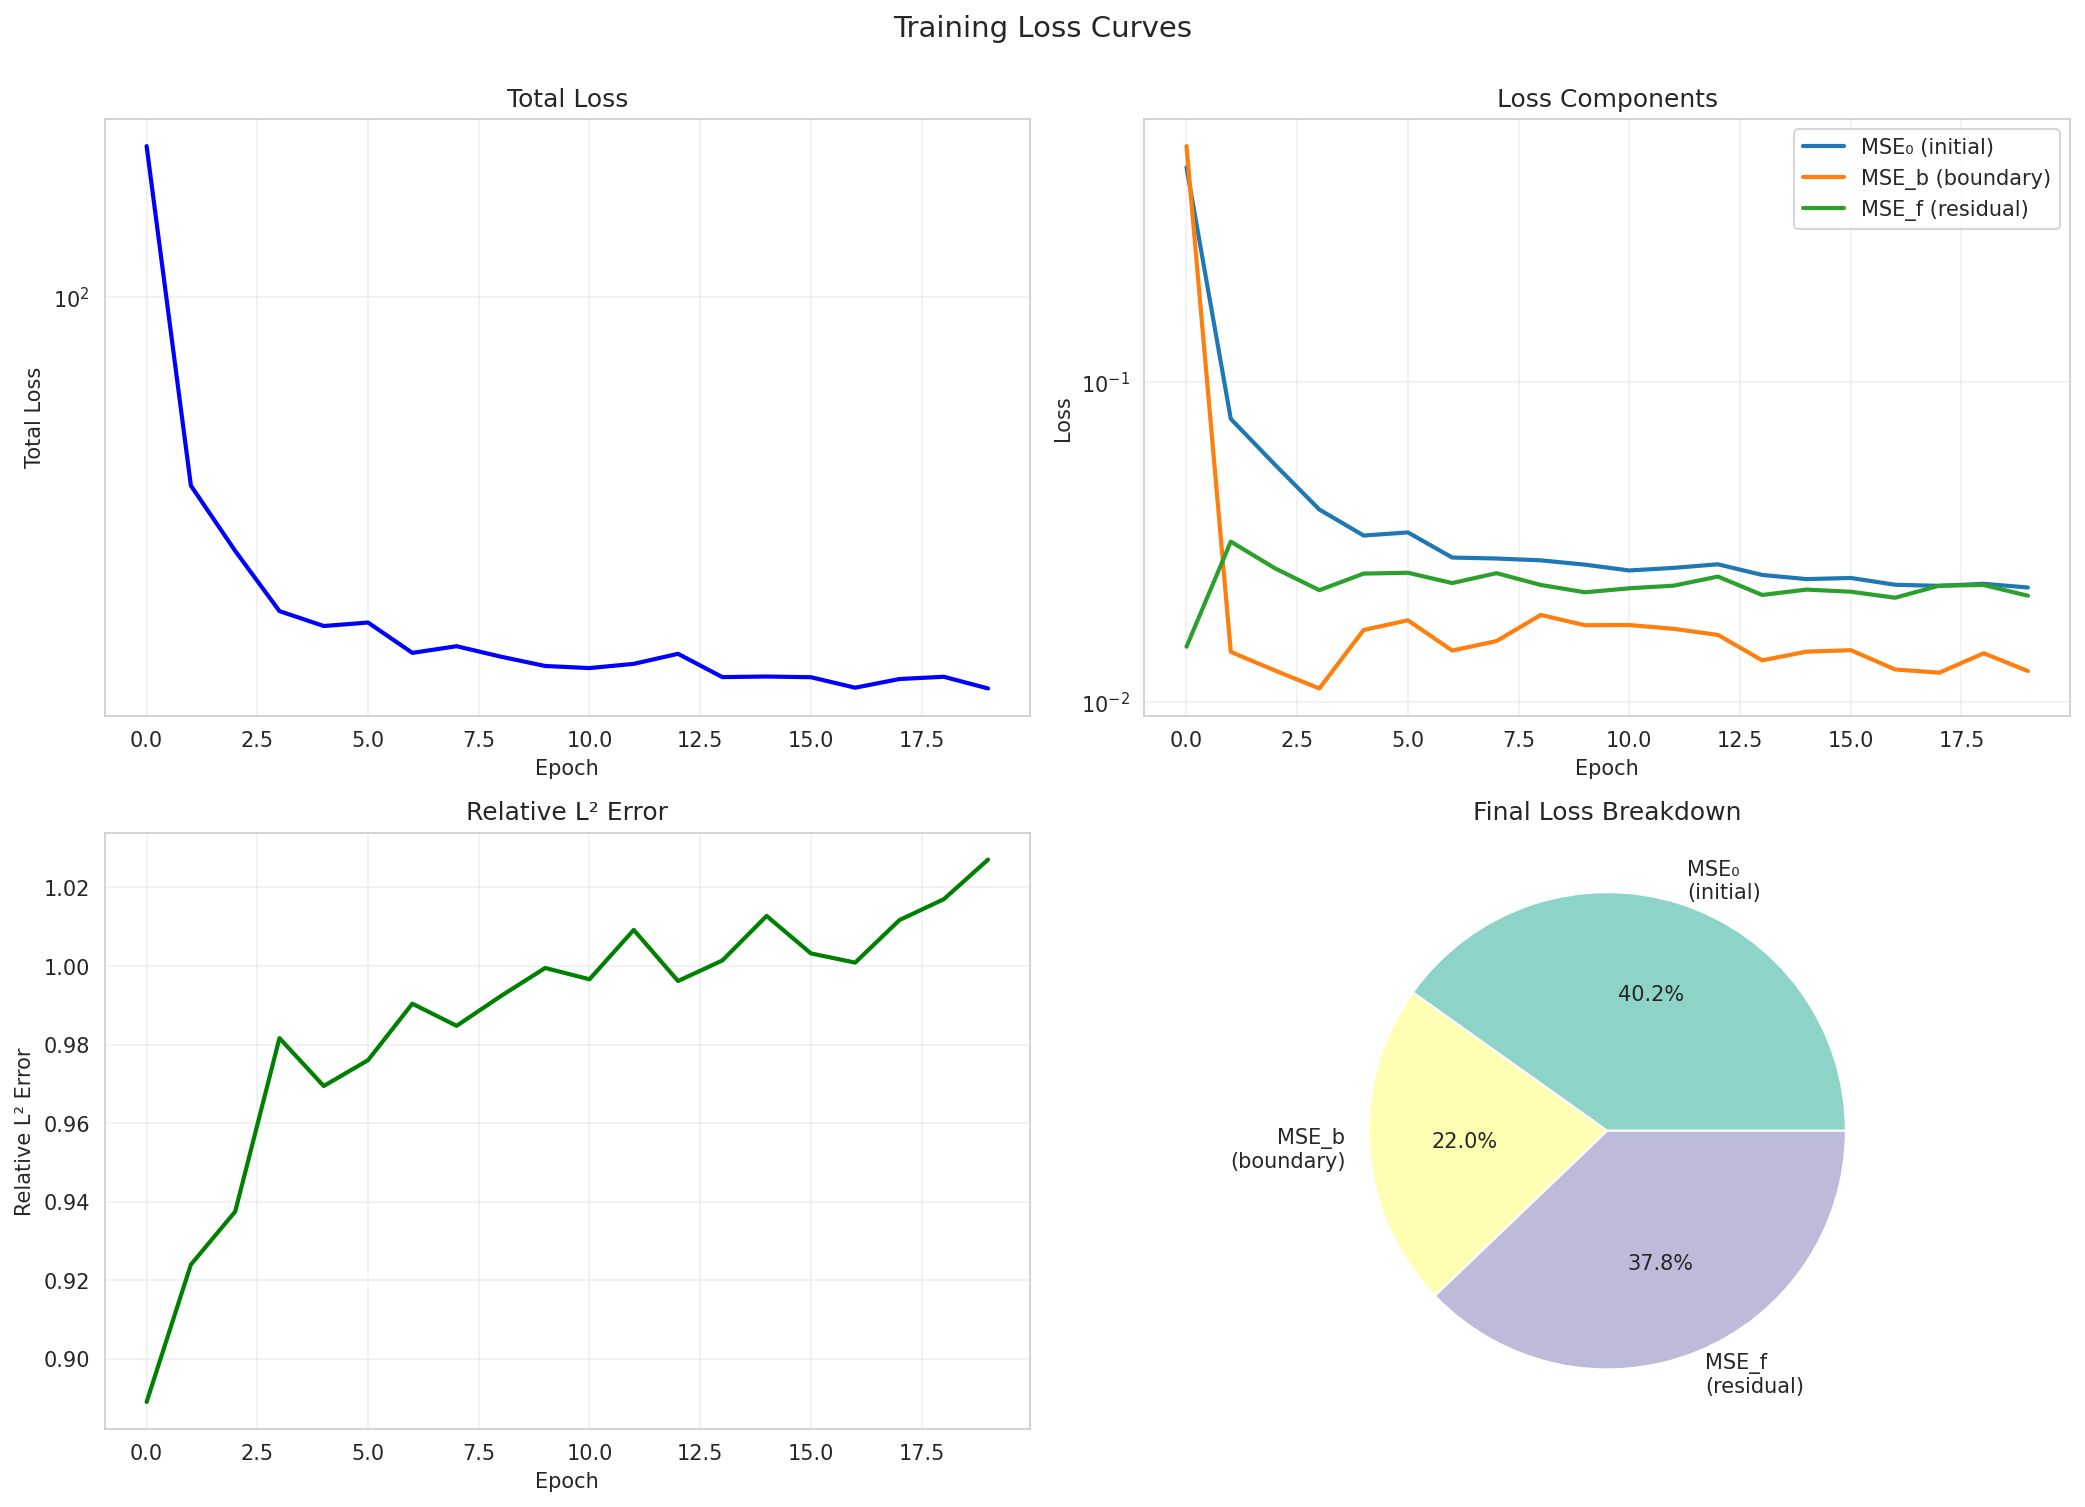


Training Evolution:


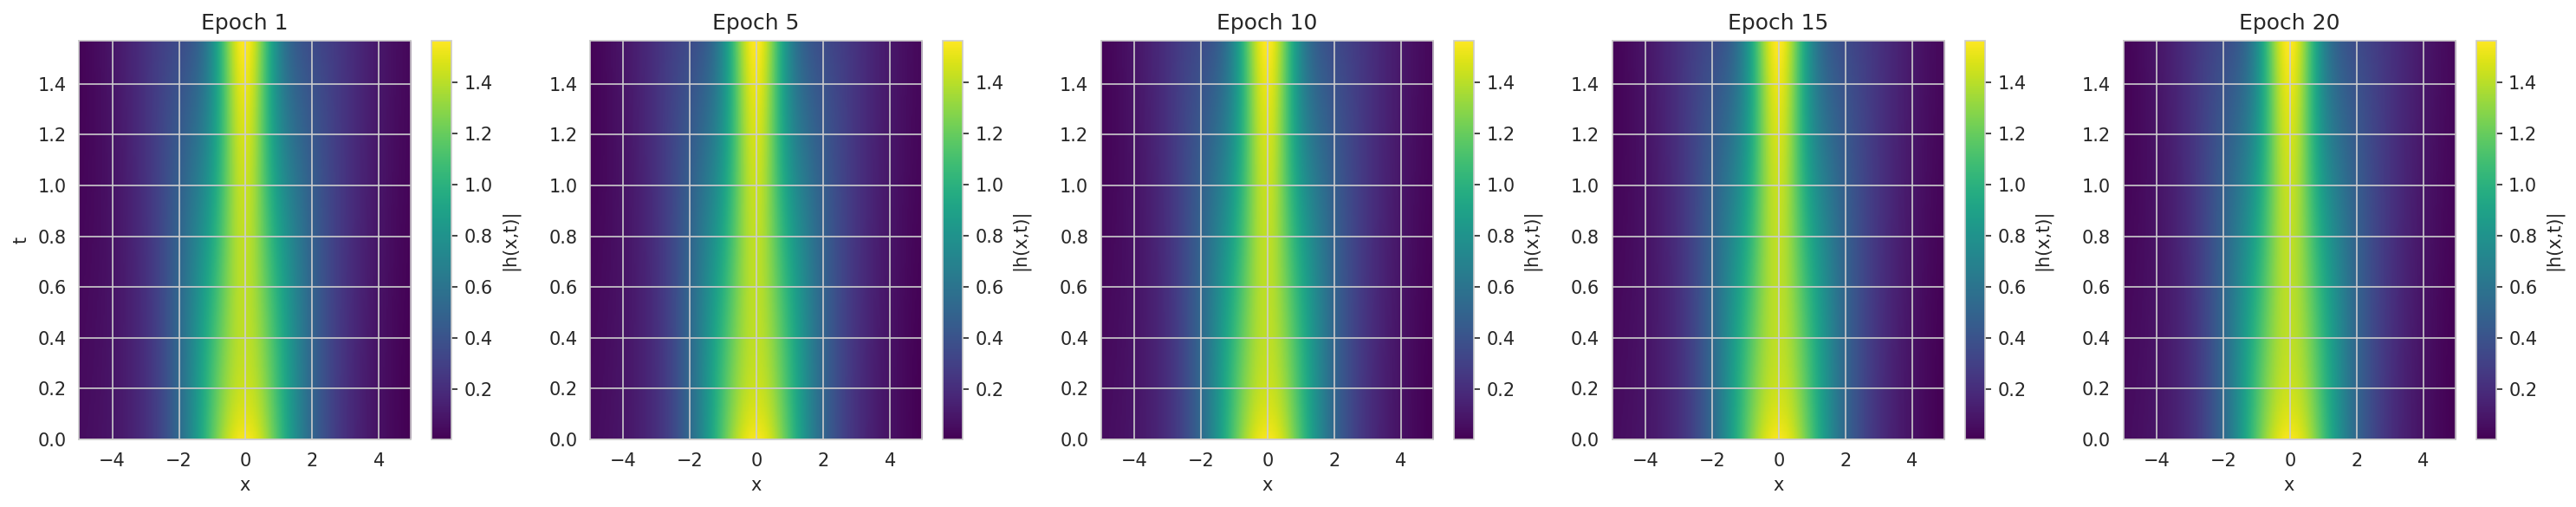

In [11]:
from IPython.display import Image, display
import glob

# Find the most recent run
plot_dirs = sorted(Path("outputs/plots").glob("*"), key=lambda x: x.stat().st_mtime, reverse=True)

if plot_dirs:
    latest_run = plot_dirs[0]
    print(f"Displaying plots from run: {latest_run.name}\n")

    # Training curves
    training_curves = latest_run / "training_curves.png"
    if training_curves.exists():
        print("Training Loss Curves:")
        display(Image(filename=str(training_curves)))

    # Training evolution
    training_evolution = latest_run / "training_evolution.png"
    if training_evolution.exists():
        print("\nTraining Evolution:")
        display(Image(filename=str(training_evolution)))

    # Evaluation plots
    eval_dir = Path("outputs/evaluation") / latest_run.name
    if eval_dir.exists():
        comparison_plot = eval_dir / "model_vs_solver_comparison.png"
        if comparison_plot.exists():
            print("\nModel vs Solver Comparison:")
            display(Image(filename=str(comparison_plot)))
else:
    print("No plot directories found.")


## Notes & Tips

The section below provides important information about the notebook setup and usage.

---

## Notes

**Grid Search Configuration:**
- Edit `config/grid_search.yaml` to customize parameters
- Default: searches over IC weights, residual weights, and batch sizes

**MLflow Tracking:**
- All runs are tracked in `mlruns/` directory
- Each run has a unique ID and stores all metrics/artifacts

**Outputs:**
- `outputs/plots/{run_id}/`: Training curves and evolution plots
- `outputs/evaluation/{run_id}/`: Model evaluation and comparison plots
- `outputs/checkpoints/`: Saved model checkpoints (best + final)
- `outputs/grid_search_results.csv`: Summary table of all runs

**Tips:**
- Use GPU runtime (Runtime → Change runtime type → GPU)
- For long runs, keep the browser tab open or use Colab Pro
- Results are auto-saved to Drive, so they persist even if Colab disconnects

---
